# LAB | Ensemble Methods

**Load the data**

In this challenge, we will be working with the same Spaceship Titanic data, like the previous Lab. The data can be found here:

https://raw.githubusercontent.com/data-bootcamp-v4/data/main/spaceship_titanic.csv

Metadata

https://github.com/data-bootcamp-v4/data/blob/main/spaceship_titanic.md

In this Lab, you should try different ensemble methods in order to see if can obtain a better model than before. In order to do a fair comparison, you should perform the same feature scaling, engineering applied in previous Lab.

In [40]:
#Libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [41]:
spaceship = pd.read_csv("https://raw.githubusercontent.com/data-bootcamp-v4/data/main/spaceship_titanic.csv")
spaceship.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


Now perform the same as before:
- Feature Scaling
- Feature Selection


In [42]:
spaceship.describe()
spaceship.info()
spaceship.dropna(inplace=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [43]:
spaceship_2 = spaceship.drop(columns=["Name", "PassengerId", "HomePlanet", "CryoSleep", "Cabin", "Destination"])

features = spaceship_2.drop("Transported", axis=1)
target = spaceship_2["Transported"]

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.20, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

X_test_scaled = scaler.transform(X_test)

X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns)

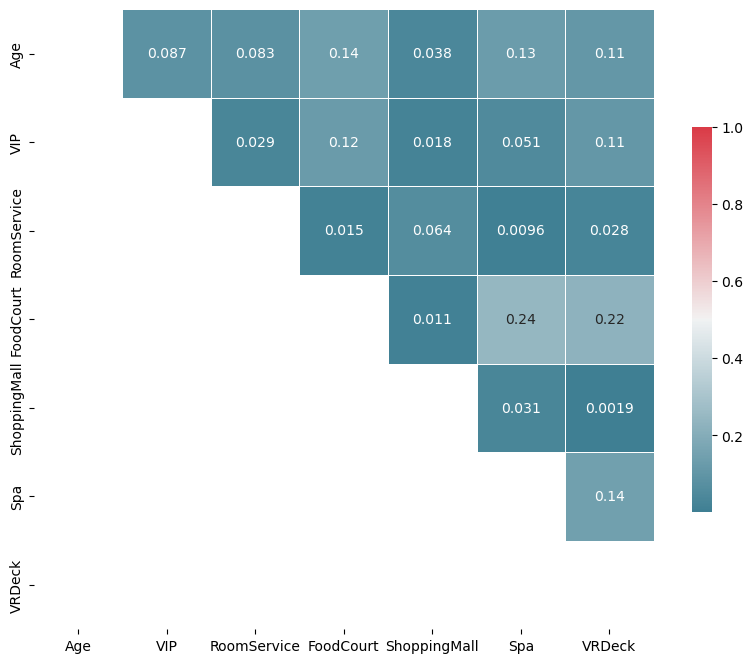

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns

corr = np.abs(X_train_scaled_df.corr())

mask = np.zeros_like(corr, dtype=bool)
mask[np.tril_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(10, 10))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)
plt.show()

**Perform Train Test Split**

In [45]:
spaceship_reduced = spaceship_2.drop(columns=["Age", "VIP", "FoodCourt"])

**Model Selection** - now you will try to apply different ensemble methods in order to get a better model

- Bagging and Pasting

In [46]:
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor,AdaBoostRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

bagging_reg = BaggingRegressor(DecisionTreeRegressor(max_depth=20),
                               n_estimators=100,
                               max_samples = 1000)

bagging_reg.fit(X_train, y_train)

pred = bagging_reg.predict(X_test)

print("MAE", mean_absolute_error(pred, y_test))
print("RMSE", mean_squared_error(pred, y_test, squared=False))
print("R2 score", bagging_reg.score(X_test, y_test))

MAE 0.31263309738054373
RMSE 0.39303417883791064
R2 score 0.38200601356773023


c:\Users\crist\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


- Random Forests

In [47]:
forest = RandomForestRegressor(n_estimators=100,
                             max_depth=20)
forest.fit(X_train, y_train)
pred = forest.predict(X_test)

print("MAE", mean_absolute_error(pred, y_test))
print("RMSE", mean_squared_error(pred, y_test, squared=False))
print("R2 score", forest.score(X_test, y_test))

MAE 0.3092629633170897
RMSE 0.4005652665625362
R2 score 0.3580958430501455


c:\Users\crist\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


- Gradient Boosting

In [48]:
gb_reg = GradientBoostingRegressor(max_depth=20,
                                   n_estimators=100)
gb_reg.fit(X_train, y_train)
pred = gb_reg.predict(X_test)

print("MAE", mean_absolute_error(pred, y_test))
print("RMSE", mean_squared_error(pred, y_test, squared=False))
print("R2 score", gb_reg.score(X_test, y_test))

MAE 0.30964814639248284
RMSE 0.46182464568755166
R2 score 0.14674700241047955


c:\Users\crist\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


- Adaptive Boosting

In [49]:
ada_reg = AdaBoostRegressor(DecisionTreeRegressor(max_depth=20),
                            n_estimators=100)
ada_reg.fit(X_train, y_train)

pred = ada_reg.predict(X_test)

print("MAE", mean_absolute_error(pred, y_test))
print("RMSE", mean_squared_error(pred, y_test, squared=False))
print("R2 score", ada_reg.score(X_test, y_test))

MAE 0.32918691944941797
RMSE 0.4581430285482896
R2 score 0.16029686221624617


c:\Users\crist\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Which model is the best and why?

In [50]:
## Bagging is the best model because it has the lowest MAE and RMSE, and highest R2score